## Proceso de EDA previo a la construcción del modelo de Machine Laarning

Importamos las librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
%xmode minimal

Exception reporting mode: Minimal


Leemos la data desde el archivo de parquet producto del ETL

In [3]:
df = pd.read_parquet('steam_data_clean.parquet')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32129 entries, 0 to 32128
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   publisher     24078 non-null  string        
 1   genres        28847 non-null  object        
 2   app_name      32128 non-null  string        
 3   release_date  29889 non-null  datetime64[ns]
 4   specs         31460 non-null  object        
 5   price         30880 non-null  float64       
 6   early_access  32129 non-null  bool          
 7   developer     28831 non-null  string        
 8   sentiment     15259 non-null  string        
 9   metascore     2607 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(2), object(2), string(4)
memory usage: 2.2+ MB


Como el objetivo de esta etapa es armar el modelo de predicción de precios, eliminamos todas las filas que no tengan precios

In [5]:
df.dropna(subset=['price'], inplace=True)

In [6]:
df.reset_index(drop=True, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30880 entries, 0 to 30879
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   publisher     23083 non-null  string        
 1   genres        27748 non-null  object        
 2   app_name      30880 non-null  string        
 3   release_date  28932 non-null  datetime64[ns]
 4   specs         30228 non-null  object        
 5   price         30880 non-null  float64       
 6   early_access  30880 non-null  bool          
 7   developer     27725 non-null  string        
 8   sentiment     14856 non-null  string        
 9   metascore     2585 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(2), object(2), string(4)
memory usage: 2.1+ MB


Hacemos una primera observación con una matriz de correlación

<Axes: >

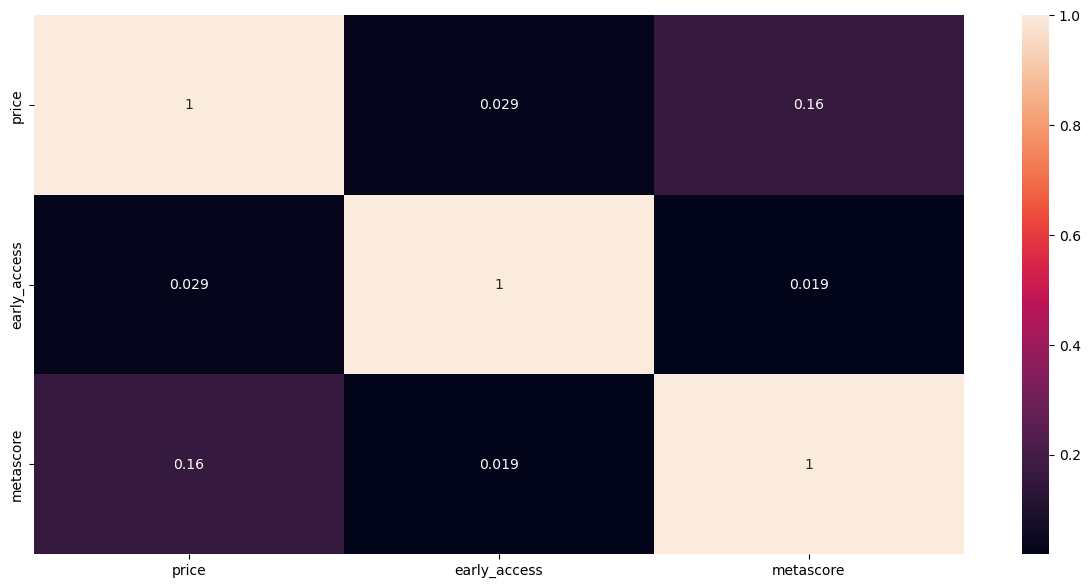

In [8]:
plt.figure(figsize=(15,7))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)

Hay muy pocos datos de tipo numérico, vamos a tener que empezar a ampliar nuestro panorama

Creamos una nueva columna para hacer observaciones de tiempo

In [9]:
# Calculamos la fecha máxima
latest_date = df['release_date'].max()

# Calculamos una columna con la cantidad de meses transucrridos desde el relase a la fecha máxima
df['release_age_months'] = round((latest_date - df['release_date']).dt.days / (365.25/12), 0)
df['release_age_months'] = pd.to_numeric(df['release_age_months'], errors='coerce').astype('Int64')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30880 entries, 0 to 30879
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   publisher           23083 non-null  string        
 1   genres              27748 non-null  object        
 2   app_name            30880 non-null  string        
 3   release_date        28932 non-null  datetime64[ns]
 4   specs               30228 non-null  object        
 5   price               30880 non-null  float64       
 6   early_access        30880 non-null  bool          
 7   developer           27725 non-null  string        
 8   sentiment           14856 non-null  string        
 9   metascore           2585 non-null   float64       
 10  release_age_months  28932 non-null  Int64         
dtypes: Int64(1), bool(1), datetime64[ns](1), float64(2), object(2), string(4)
memory usage: 2.4+ MB


Observamos cómo se comporta esta nueva columna respecto al precio

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

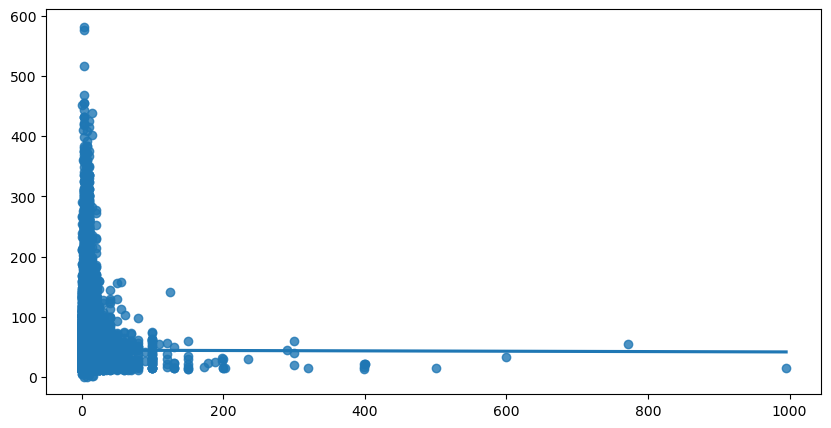

In [11]:
plt.figure(figsize=(10,5))
sns.regplot(x='price',y='release_age_months',data=df)

Hagamos un análisis de outliers estadístico, usando la "regla" de las 3 desviaciones estándar

In [12]:
# Calculamos z scores
z_scores = stats.zscore(df['price'])

# Definimos un límite positivo (dado que hay muchísimos precios 0 y no hay negativos)
pos = 3

# Máscara outliers
outliers_mask = z_scores > pos

# DF sin outliers
df_no_outliers = df.drop(df[outliers_mask].index)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

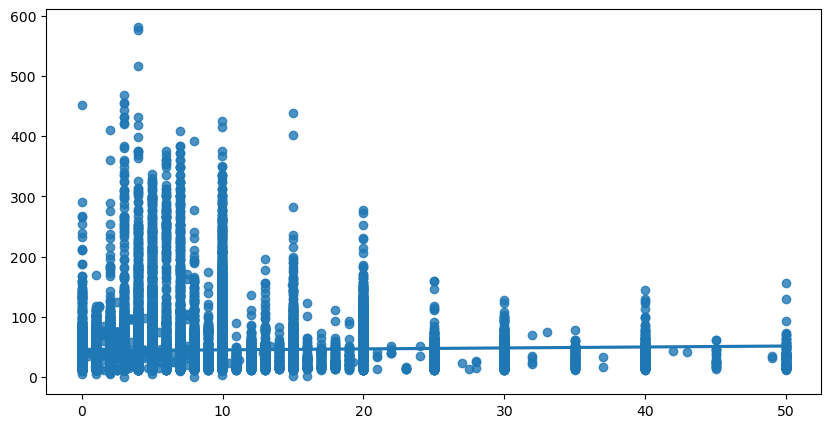

In [13]:
plt.figure(figsize=(10,5))
sns.regplot(x='price',y='release_age_months',data=df_no_outliers)

Muchísimos registros quedan afuera. Vamos a probar un método menos estadístico, usando un límite observado en el gráfico anterior, precio 200

In [14]:
df_200 = df[df['price'] < 200]

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

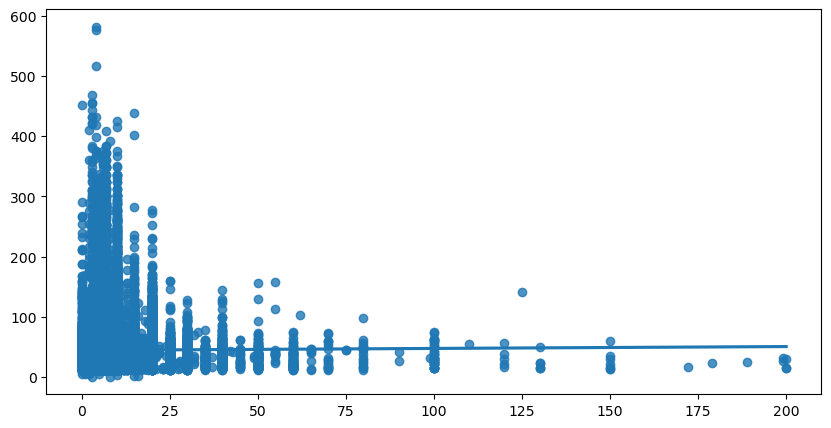

In [15]:
plt.figure(figsize=(10,5))
sns.regplot(x='price',y='release_age_months',data=df_200)

Interesante! Casi todo el dataset está acá, y vemos algunas cuestiones:

* Si la edad del release es mayor a aproximadamente 180 meses (15 años), los precios de los juegos están concentrados por debajo de 25
* Si la edad del release es menor, la dispersión de precios es notable. La mayoría aún se concentra entre 0 y 25, pero hay muchos puntos por encima de ese rango también

Vamos a agregar columnas calculadas de cantidad de juegos por developer y el precio promedio por developer

In [16]:
df_200['developer_total'] = df_200.groupby('developer')['developer'].transform('size')

In [17]:
df_200['avg_dev'] = df_200.groupby('developer')['price'].transform('mean')

In [19]:
df_200.head(10)

,publisher,genres,app_name,release_date,specs,price,early_access,developer,sentiment,metascore,release_age_months,developer_total,avg_dev
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,[Single-player],4.99,False,Kotoshiro,<NA>,NaN,12,1.0,4.99
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,Secret Level SRL,Mostly Positive,NaN,12,1.0,0.00
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,Poolians.com,Mostly Positive,NaN,17,1.0,0.00
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,[Single-player],0.99,False,彼岸领域,<NA>,NaN,13,1.0,0.99
4,<NA>,None,Log Challenge,NaT,"[Single-player, Full controller support, HTC V...",2.99,False,<NA>,<NA>,NaN,<NA>,NaN,NaN
5,Trickjump Games Ltd,"[Action, Adventure, Simulation]",Battle Royale Trainer,2018-01-04,"[Single-player, Steam Achievements]",3.99,False,Trickjump Games Ltd,Mixed,NaN,12,1.0,3.99
6,<NA>,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Basic Pass,2018-01-04,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,Poppermost Productions,<NA>,NaN,12,6.0,0.00
7,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Pro Pass,2018-01-04,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,Poppermost Productions,<NA>,NaN,12,6.0,0.00
8,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Legend Pass,2018-01-04,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,Poppermost Productions,<NA>,NaN,12,6.0,0.00
9,<NA>,None,Icarus Six Sixty Six,NaT,"[Single-player, HTC Vive, Tracked Motion Contr...",0.00,False,<NA>,<NA>,NaN,<NA>,NaN,NaN


<Axes: >

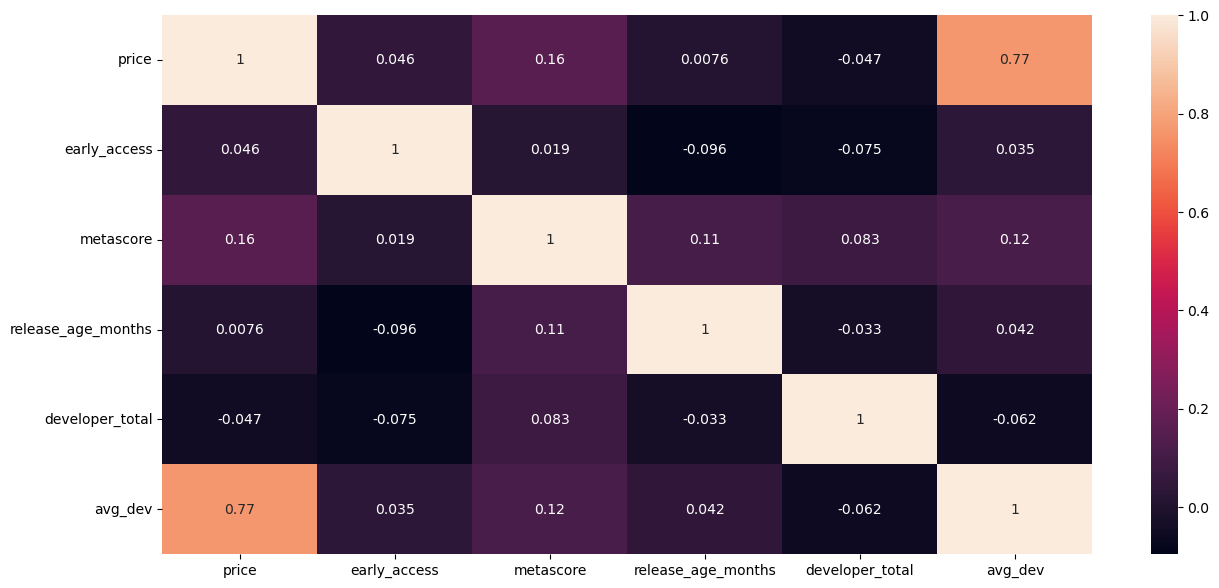

In [20]:
plt.figure(figsize=(15,7))
corr_matrix = df_200.corr()
sns.heatmap(corr_matrix, annot=True)

El precio promedio según el developer se ve como un buen indicativo

Vamos a seguir observando con dataframes segmentados

In [21]:
df_under = df_200[df_200['release_age_months'] <= 180]
df_over = df_200[df_200['release_age_months'] > 180]

Releases más viejos

<Axes: >

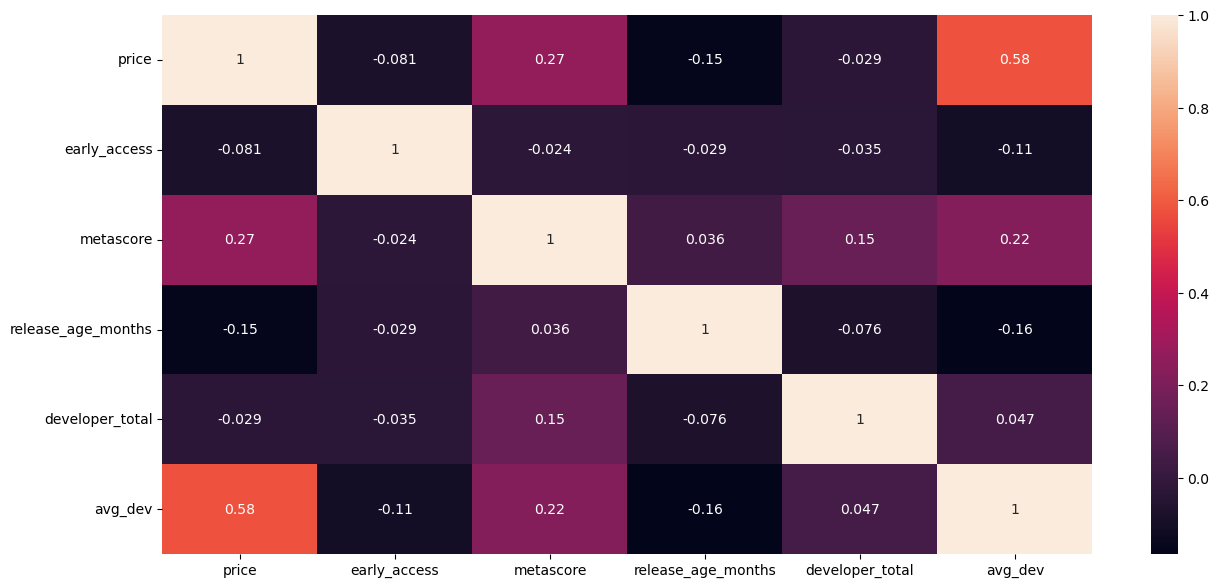

In [22]:
plt.figure(figsize=(15,7))
corr_matrix = df_over.corr()
sns.heatmap(corr_matrix, annot=True)

La fuerza del promedio es menor si el juego es viejo

Releases más nuevos

<Axes: >

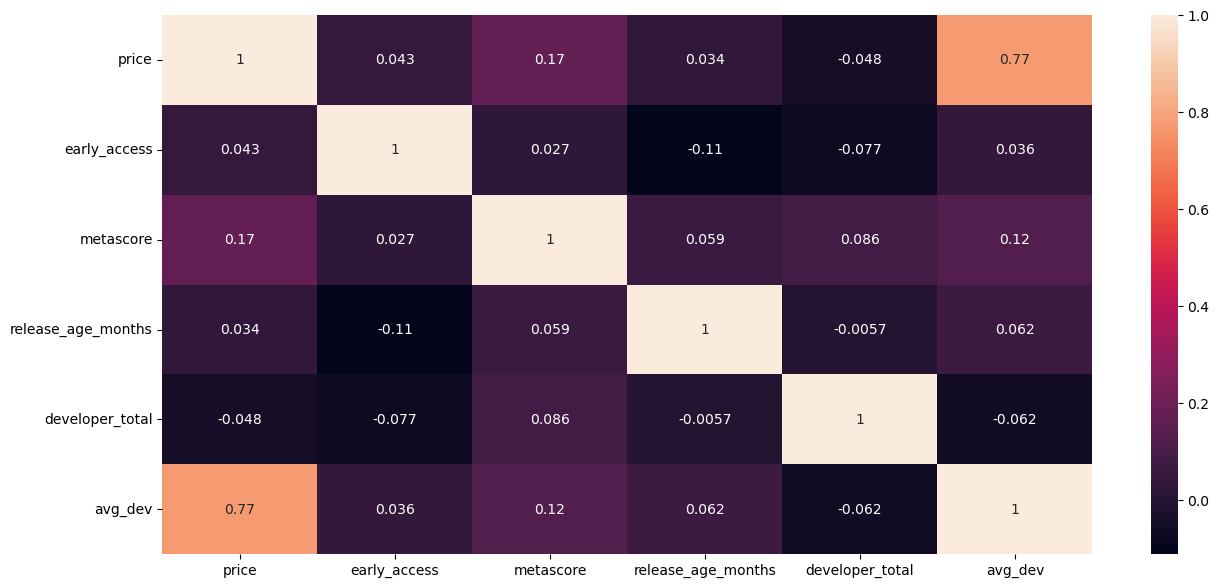

In [23]:
plt.figure(figsize=(15,7))
corr_matrix = df_under.corr()
sns.heatmap(corr_matrix, annot=True)

Vamos a separar en 4 dataframes

In [24]:
df_new_cheap = df_under[df_under['price'] < 25]
df_new_expensive = df_under[df_under['price'] >= 25]
df_old_cheap = df_over[df_over['price'] < 25]
df_old_expensive = df_over[df_over['price'] >= 25]

Nuevos Baratos

<Axes: >

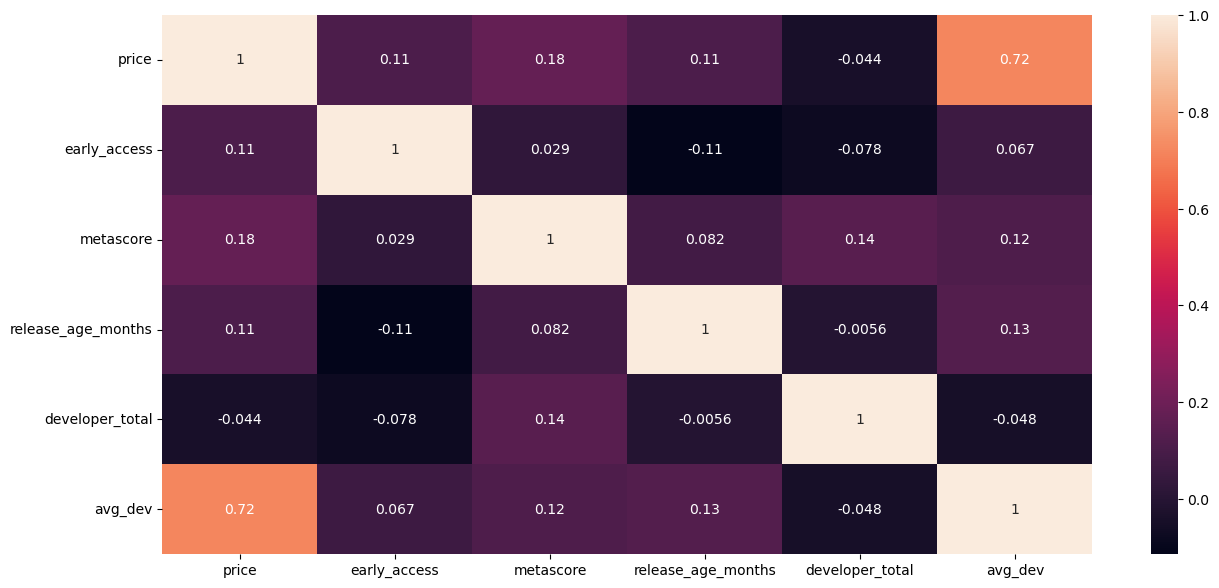

In [25]:
plt.figure(figsize=(15,7))
corr_matrix = df_new_cheap.corr()
sns.heatmap(corr_matrix, annot=True)

Nuevos Caros

<Axes: >

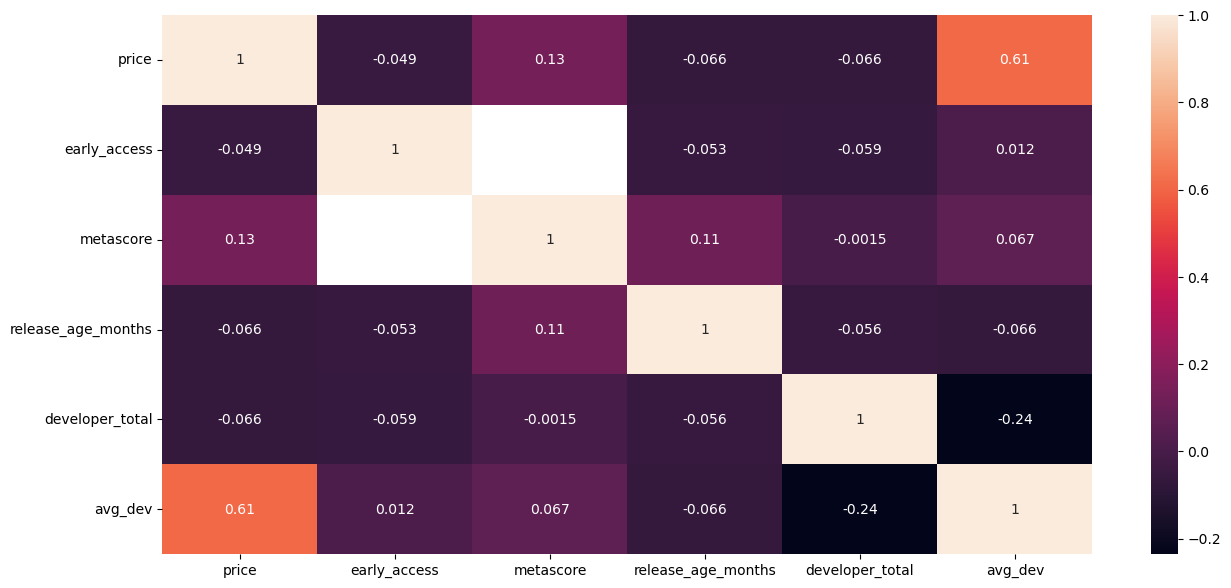

In [26]:
plt.figure(figsize=(15,7))
corr_matrix = df_new_expensive.corr()
sns.heatmap(corr_matrix, annot=True)

Viejos Baratos

<Axes: >

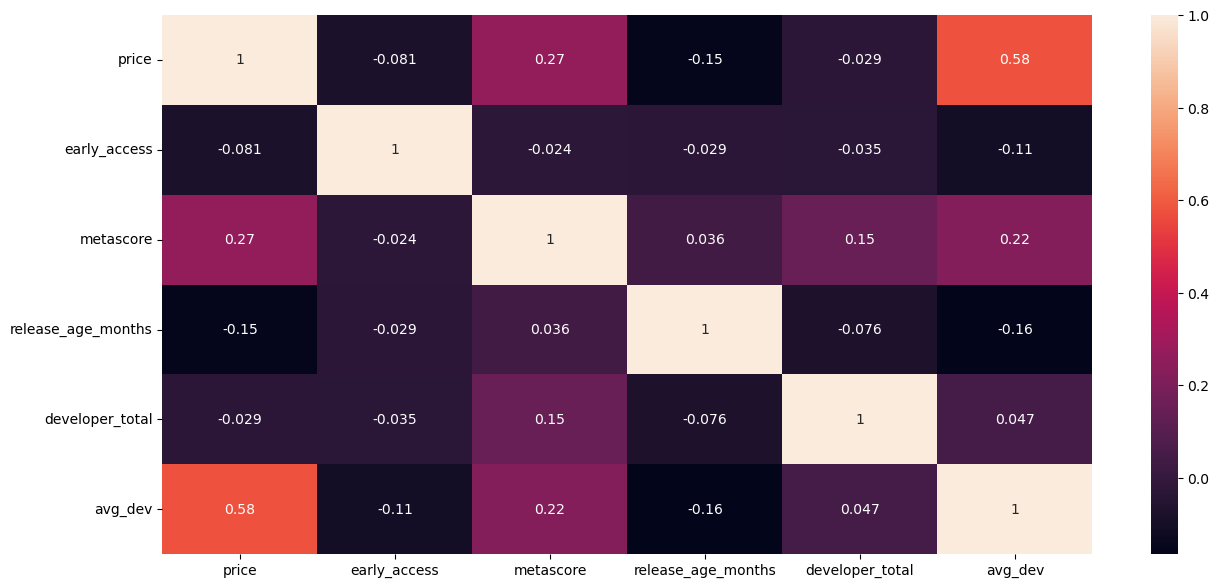

In [27]:
plt.figure(figsize=(15,7))
corr_matrix = df_old_cheap.corr()
sns.heatmap(corr_matrix, annot=True)

Viejos Caros está vacío

In [28]:
df_old_expensive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   publisher           0 non-null      string        
 1   genres              0 non-null      object        
 2   app_name            0 non-null      string        
 3   release_date        0 non-null      datetime64[ns]
 4   specs               0 non-null      object        
 5   price               0 non-null      float64       
 6   early_access        0 non-null      bool          
 7   developer           0 non-null      string        
 8   sentiment           0 non-null      string        
 9   metascore           0 non-null      float64       
 10  release_age_months  0 non-null      Int64         
 11  developer_total     0 non-null      float64       
 12  avg_dev             0 non-null      float64       
dtypes: Int64(1), bool(1), datetime64[ns](1), float64(4), object(2)

Ahora que tenemos una idea respecto a columnas numéricas (del dataset y calculadas), vamos a deshacernos de algunas columnas  y explorar las restantes

In [29]:
df_200 = df_200.drop(columns=['metascore', 'early_access', 'publisher', 'app_name'])

Metascore tiene muy pocos registros, limitando muchísimo el dataframe. Ignoramos Early acess por su poca correlación. Descartamos publisher por equivaler a developer, y app name por no aportar datos al modelo.

In [30]:
df_200.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30864 entries, 0 to 30879
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   genres              27734 non-null  object        
 1   release_date        28916 non-null  datetime64[ns]
 2   specs               30218 non-null  object        
 3   price               30864 non-null  float64       
 4   developer           27710 non-null  string        
 5   sentiment           14851 non-null  string        
 6   release_age_months  28916 non-null  Int64         
 7   developer_total     27710 non-null  float64       
 8   avg_dev             27710 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(3), object(2), string(2)
memory usage: 2.4+ MB


Exploramos Géneros

In [31]:
# Preparamos los dummies para one hot encoding
one_hot_encoded = pd.get_dummies(df_200['genres'].apply(pd.Series).stack(), dtype='float64').sum(level=0)

# Concatenamos
df_genres = pd.concat([df_200, one_hot_encoded], axis=1)

# Sacamos las columns no vamos a usar (géneros está expandida, free to play ya está en el precio y early access fue descartada)
df_genres = df_genres.drop(columns=['genres', 'Early Access', 'Free to Play'])

<Axes: >

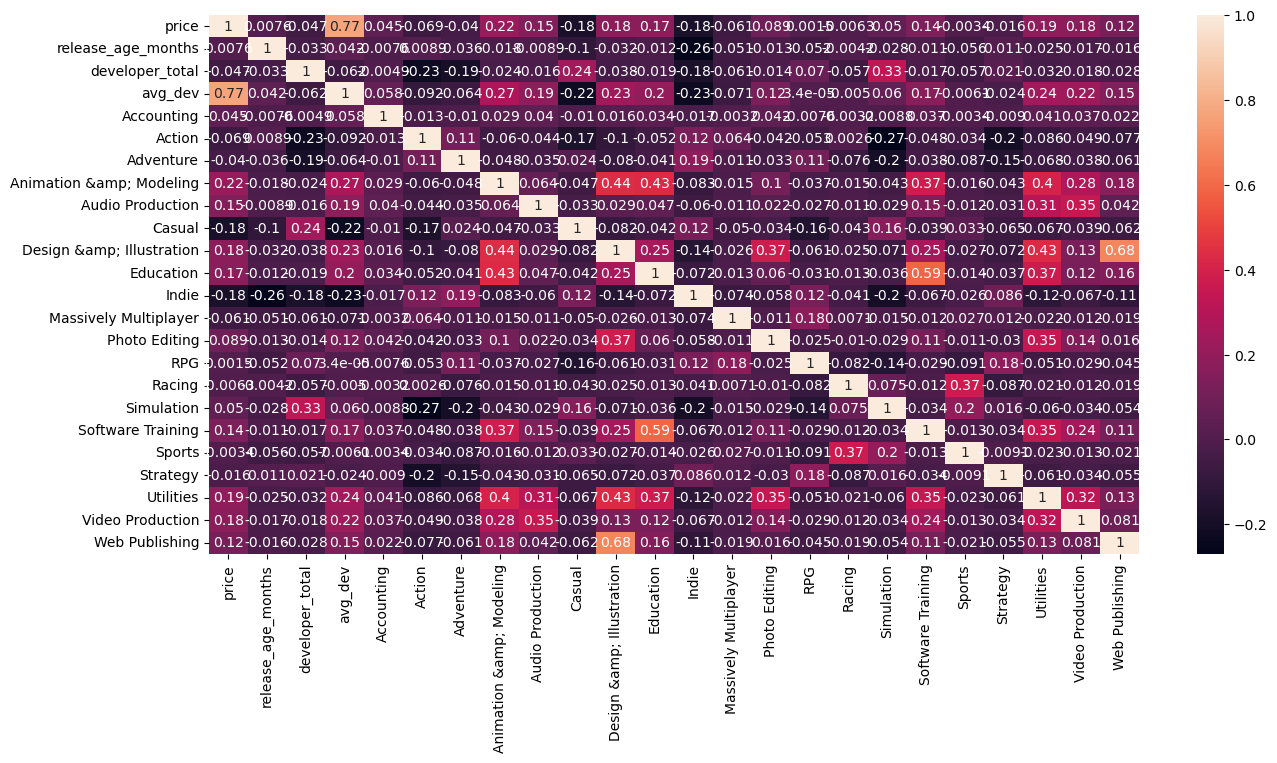

In [32]:
plt.figure(figsize=(15,7))
corr_matrix = df_genres.corr()
sns.heatmap(corr_matrix, annot=True)

Exploramos sentiments

In [33]:
unique_sentiments = df_genres.loc[~df_genres['sentiment'].str.contains('review'), 'sentiment'].unique()
unique_sentiments

<StringArray>
[        'Mostly Positive',                   'Mixed',
           'Very Positive', 'Overwhelmingly Positive',
                'Positive',         'Mostly Negative',
           'Very Negative',                'Negative',
 'Overwhelmingly Negative']
Length: 9, dtype: string

Vamos a darle una valoración numérica, donde cuanto más positivo es, más alto el puntaje

In [34]:
sentiment_dict = {
    'Overwhelmingly Positive': 5,
    'Very Positive': 4.5,
    'Mostly Positive': 4,
    'Positive': 3.5,
    'Mixed': 2.5,
    'Negative': 1.5,
    'Mostly Negative': 1,
    'Very Negative': 0.5,
    'Overwhelmingly Negative': 0
}

In [35]:
df_genres['sentiment'] = df_genres['sentiment'].map(sentiment_dict)

Ploteamos

<Axes: >

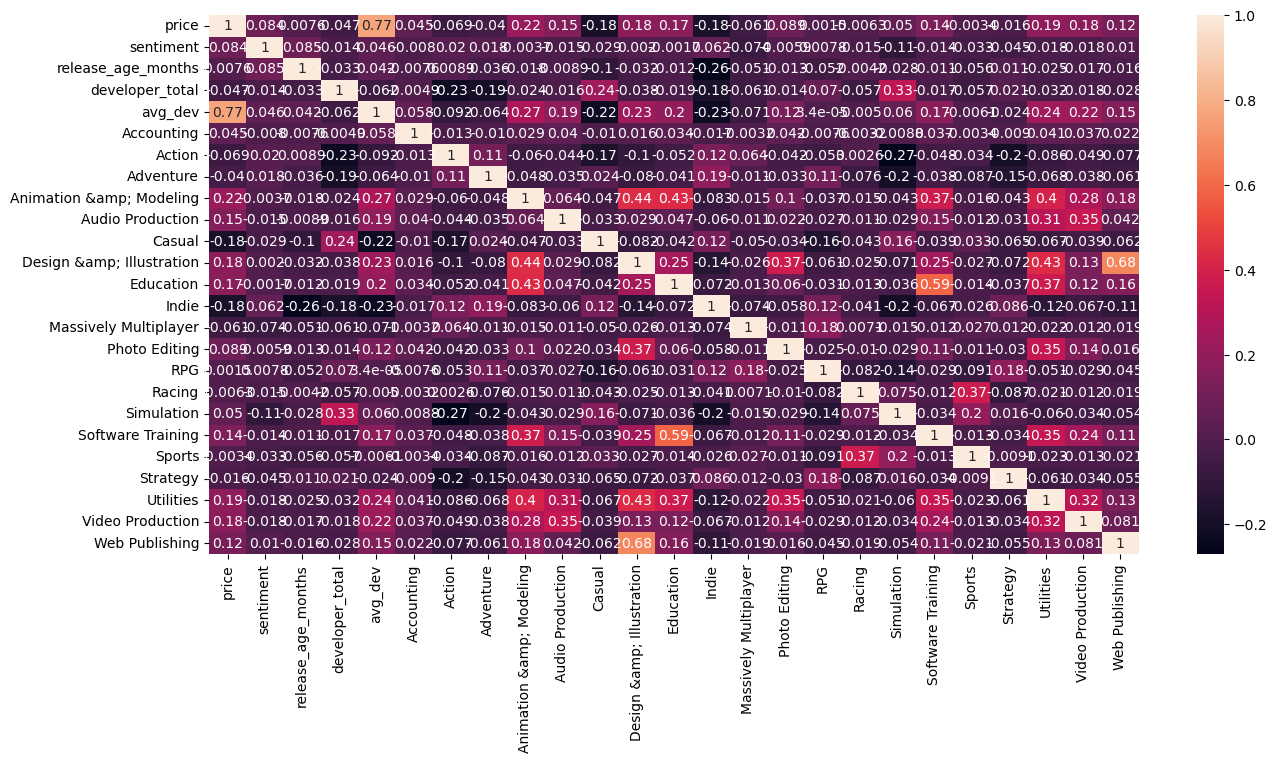

In [36]:
plt.figure(figsize=(15,7))
corr_matrix = df_genres.corr()
sns.heatmap(corr_matrix, annot=True)

In [37]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30864 entries, 0 to 30879
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   release_date               28916 non-null  datetime64[ns]
 1   specs                      30218 non-null  object        
 2   price                      30864 non-null  float64       
 3   developer                  27710 non-null  string        
 4   sentiment                  14851 non-null  float64       
 5   release_age_months         28916 non-null  Int64         
 6   developer_total            27710 non-null  float64       
 7   avg_dev                    27710 non-null  float64       
 8   Accounting                 27734 non-null  float64       
 9   Action                     27734 non-null  float64       
 10  Adventure                  27734 non-null  float64       
 11  Animation &amp; Modeling   27734 non-null  float64       
 12  Audi

Renombramos algunas columnas con problemas en sus caracteres.

In [38]:
df_genres.rename(columns={'Animation &amp; Modeling': 'Animation & Modeling', 'Design &amp; Illustration': 'Design & Illustration'}, inplace=True)

In [39]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30864 entries, 0 to 30879
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   release_date           28916 non-null  datetime64[ns]
 1   specs                  30218 non-null  object        
 2   price                  30864 non-null  float64       
 3   developer              27710 non-null  string        
 4   sentiment              14851 non-null  float64       
 5   release_age_months     28916 non-null  Int64         
 6   developer_total        27710 non-null  float64       
 7   avg_dev                27710 non-null  float64       
 8   Accounting             27734 non-null  float64       
 9   Action                 27734 non-null  float64       
 10  Adventure              27734 non-null  float64       
 11  Animation & Modeling   27734 non-null  float64       
 12  Audio Production       27734 non-null  float64       
 13  C

Nos deshacemos de sentiment, ya que deja la mitad de los registros fuera y la correlación es baja

In [40]:
df_genres.drop(['sentiment'], axis=1, inplace=True)

Comenzamos a deshacernos de las filas con NAs/NaNs, empezando por la más restrictiva y seguimos en ese orden.

In [41]:
df_model = df_genres.dropna(subset=['developer'])

Revisamos cómo va quedando

In [42]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27710 entries, 0 to 30878
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   release_date           27694 non-null  datetime64[ns]
 1   specs                  27436 non-null  object        
 2   price                  27710 non-null  float64       
 3   developer              27710 non-null  string        
 4   release_age_months     27694 non-null  Int64         
 5   developer_total        27710 non-null  float64       
 6   avg_dev                27710 non-null  float64       
 7   Accounting             27577 non-null  float64       
 8   Action                 27577 non-null  float64       
 9   Adventure              27577 non-null  float64       
 10  Animation & Modeling   27577 non-null  float64       
 11  Audio Production       27577 non-null  float64       
 12  Casual                 27577 non-null  float64       
 13  D

Usamos la columna 'Action' en nombre de todas las columnas que derivaron de genre.

In [43]:
df_model = df_model.dropna(subset=['Action'])

Seguimos por release date

In [44]:
df_model = df_model.dropna(subset=['release_date'])

Decido eliminar specs, de acuerdo a los observado en el diccionario de datos.

In [45]:
df_model.drop(['specs'], axis=1, inplace=True)

In [46]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27561 entries, 0 to 30878
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   release_date           27561 non-null  datetime64[ns]
 1   price                  27561 non-null  float64       
 2   developer              27561 non-null  string        
 3   release_age_months     27561 non-null  Int64         
 4   developer_total        27561 non-null  float64       
 5   avg_dev                27561 non-null  float64       
 6   Accounting             27561 non-null  float64       
 7   Action                 27561 non-null  float64       
 8   Adventure              27561 non-null  float64       
 9   Animation & Modeling   27561 non-null  float64       
 10  Audio Production       27561 non-null  float64       
 11  Casual                 27561 non-null  float64       
 12  Design & Illustration  27561 non-null  float64       
 13  E

Reinicio el index

In [47]:
df_model.reset_index(drop=True, inplace=True)

Doy un nombre al archivo

In [48]:
parquet_file = 'steam_data_model.parquet'

Guardo la data para el modelo

In [49]:
df_model.to_parquet(parquet_file, engine="pyarrow", use_deprecated_int96_timestamps=True)